In [18]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.utils import save_image
from util import stopwatch, get_stopwatch
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

save_img_row_size = 8
label_list = "plane autos birds cats_ deer_ dogs_ frogs horse ships truck".split(" ")
def save_labels(labels, path):
    with open(path, 'w') as f:
        for i, label in enumerate(labels.detach().numpy()):
            l = np.where(label==1)[0][0]
            print(label_list[l], file=f, end=('\n' if (i+1) % save_img_row_size == 0 else ' '))
torch.manual_seed(7)

In [7]:
num_epochs = 500
batch_size = 100
num_labels = 10

sample_dir = 'cifar_aux_onehot_v3'
if not os.path.exists(sample_dir): os.makedirs(sample_dir)
    
fake_img_dir = os.path.join(sample_dir, 'fake_images')
if not os.path.exists(fake_img_dir): os.makedirs(fake_img_dir)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))])
def denorm(x): return ((x+1)/2).clamp(0,1)

def one_hot(x):
    r = torch.zeros(num_labels)
    try: r[x] = 1
    except: r[x.item()] = 1
    return r
def one_hot_multi(x):
    r = torch.zeros([x.shape[0], num_labels] + list(x.shape[2:])).to(device)
    r.scatter_(1, x.unsqueeze(1), 1)
    return r
dataset = torchvision.datasets.CIFAR10(root='~/cifar10-data/', train=True, download=True,
                                   transform=transform) #, target_transform=one_hot) <- not using since using embedding

data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size = batch_size, shuffle=True)

Files already downloaded and verified


50000 images of torch.Size([3, 32, 32])
1
torch.Size([3, 32, 32])


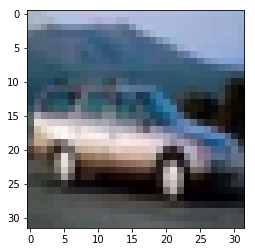

In [8]:
from matplotlib import pyplot as plt
show_i = 4
print("{} images of {}".format(len(dataset), dataset[1][0].shape))
print(dataset[show_i][1])
print(dataset[show_i][0].shape)
plt.imshow(denorm(dataset[show_i][0].permute(1,2,0)))

In [9]:
latent_size = 64
image_size = 32 * 32
num_colors = 3
num_kernels = 32
embedding_size = 64

In [21]:
class Discriminator(nn.Module):
    def __init__(self, E):
        super(Discriminator, self).__init__()
        self.D1 = nn.Sequential(
                    # add label to each pixel in input. (10+3) * 32 * 32
                    nn.Conv2d(num_labels+num_colors, num_kernels, 2, 2, 0),
                    # 32x16x16
                    nn.LeakyReLU(0.2),
                    nn.Conv2d(num_kernels, num_kernels*2, 3, 2, 1),
                    # 64x8x8
                    nn.BatchNorm2d(num_kernels * 2),
                    nn.LeakyReLU(0.2),
                    nn.Conv2d(num_kernels*2, num_kernels*4, 2, 1),
                    # 128x7x7
                    nn.BatchNorm2d(num_kernels * 4),
                    nn.LeakyReLU(0.2),
                    nn.Conv2d(num_kernels*4, num_kernels*8, 2, 2),
                    # 256x3x3
                    nn.BatchNorm2d(num_kernels * 8),
                    nn.LeakyReLU(0.2))
        self.D2 = nn.Sequential(nn.Conv2d(num_kernels*8, 1, 3), nn.Sigmoid())
        self.C = nn.Linear(num_kernels * 8 * 3 * 3, num_labels)
        self.E = E
        
    def get_embedding(self, images, labels):
        embeddings = one_hot_multi(labels)
        embeddings_dups = embeddings.unsqueeze(dim=-1).unsqueeze(dim=-1).expand(embeddings.shape+images.shape[2:])
        d_inputs = torch.cat((images, embeddings_dups), 1)
        return self.D1(d_inputs)
    
    def forward(self, images, labels):
        e = self.get_embedding(images, labels)
        e_flat = e.view(-1, num_kernels * 8 * 3 * 3)
        # probability of being real, log(class probabilities)
        return self.D2(e), F.log_softmax(self.C(e_flat), dim=1)
E_D = nn.Embedding(num_labels, embedding_size)
D = Discriminator(E_D)
D = D.to(device)
D_losses = []

In [22]:
class Generator(nn.Module):
    def __init__(self, E):
        super(Generator, self).__init__()
        self.G = nn.Sequential(
                    nn.ConvTranspose2d(latent_size+num_labels, num_kernels*8, 3, 1, 0),
                    # 256x3x3
                    nn.BatchNorm2d(num_kernels*8),
                    nn.ReLU(),
                    nn.ConvTranspose2d(num_kernels*8, num_kernels*4, 2, 2, 1),
                    # 128x5x5
                    nn.BatchNorm2d(num_kernels*4),
                    nn.ReLU(),
                    nn.ConvTranspose2d(num_kernels*4, num_kernels*2, 2, 2, 0, 1),
                    # 64x9x9
                    nn.BatchNorm2d(num_kernels*2),
                    nn.ReLU(),
                    nn.ConvTranspose2d(num_kernels*2, num_kernels*3//2, 3, 2, 1),
                    nn.BatchNorm2d(num_kernels*3//2),
                    nn.ReLU(),
                    nn.ConvTranspose2d(num_kernels*3//2, num_kernels, 2, 1, 1),
                    # 32x16x16
                    nn.BatchNorm2d(num_kernels),
                    nn.ReLU(),
                    nn.ConvTranspose2d(num_kernels, num_colors, 2, 2, 0),
                    nn.Tanh())
        self.E = E
    
    def forward(self, labels, z=None):
        if z is None: z = torch.randn(labels.shape[0], latent_size)
        z = z.to(device)
        embeddings = one_hot_multi(labels)
        g_inputs = torch.cat((z, embeddings), 1) # batch_size * latent_dim
        g_inputs = g_inputs.unsqueeze(-1).unsqueeze(-1) # -> batch_size * latent_dim * 1 * 1 for DC generator
        return self.G(g_inputs)
E_G = nn.Embedding(num_labels, embedding_size)
G = Generator(E_G)
G = G.to(device)
G_losses = []

In [23]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

def reset_grad(): d_optimizer.zero_grad(); g_optimizer.zero_grad()

In [24]:
def save_generated_images(G, epoch, labels = None, z = None, nrow = 10):
    if labels is None:
        labels = torch.LongTensor([i//10 for i in range(100)]).to(device)
    fake_images = G(labels, z)
    save_image(denorm(fake_images), os.path.join(fake_img_dir, 'fake_images-{}.png'.format(epoch+1)), nrow=nrow)

In [25]:
import pickle as pkl

total_step = len(data_loader)
demo_z = torch.randn(100, latent_size)
for epoch in range(num_epochs):
    stopwatch()
    pkl.dump({'D_losses': D_losses, 'G_losses': G_losses}, open(os.path.join(sample_dir, 'losses.pkl'), 'wb'))
    D_loss_this_epoch = []
    G_loss_this_epoch = []
    D_losses.append(D_loss_this_epoch)
    G_losses.append(G_loss_this_epoch)
    G.train()
    D.train()
    
    for i, (images, labels_cpu) in enumerate(data_loader):
        real_labels = torch.ones (batch_size, 1, 1, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1, 1, 1).to(device)
        labels = labels_cpu.to(device)
        
        ## discriminator
        # input real images to discriminator
        images = images.to(device)
        outputs, class_probs = D(images, labels)
        d_loss_real = criterion(outputs, real_labels)
        c_loss_real = F.nll_loss(class_probs, labels)
        real_score = outputs
        
        # generate fake images and feed to discriminator
        fake_images = G(labels)
        outputs, class_probs = D(fake_images, labels)
        d_loss_fake = criterion(outputs, fake_labels)
        c_loss_fake = F.nll_loss(class_probs, labels)
        fake_score = outputs
        
        # compute total loss and backprop
        d_loss = d_loss_real + d_loss_fake + c_loss_fake + c_loss_real
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        
        ## generator
        # generate fake images and feed to discriminator
        fake_images = G(labels)
        outputs, class_probs = D(fake_images, labels)
        c_loss = F.nll_loss(class_probs, labels)
        
        # compute loss for generator and backprop
        g_loss = criterion(outputs, real_labels) + c_loss
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 25 == 0:
            # only gets a subsample of the losses but that's okay
            D_loss_this_epoch.append(d_loss.item())
            G_loss_this_epoch.append(g_loss.item())
            t = get_stopwatch()
            print('Epoch [{}/{}], [{}/{}] ({:.1f}s/{:.1f}s) dl({:.4f}) gl({:.4f}), D(x)={:.2f}, D(G(z))={:.2f}'
                  .format(epoch, num_epochs, i+1, total_step,
                          t, t*total_step/i,
                          d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()), end="\r")
    print("")
    if epoch == 0: save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    if epoch < 10 or \
       (epoch < 100 and (epoch+1) % 5 == 0) or \
       (epoch < 200 and (epoch+1) % 10 == 0) or \
       (epoch+1) % 20 == 0: save_generated_images(G, epoch, z = demo_z)
    
    if (epoch+1) % 20 == 0:
        torch.save(G.state_dict(), os.path.join(sample_dir, 'G_cond_{}.ckpt'.format(epoch)))
        torch.save(D.state_dict(), os.path.join(sample_dir, 'D_cond_{}.ckpt'.format(epoch)))


Epoch [0/500], [500/500] (94.7s/94.9s) dl(0.8707) gl(2.6666), D(x)=0.62, D(G(z))=0.125
Epoch [1/500], [500/500] (73.8s/73.9s) dl(0.3094) gl(3.4577), D(x)=0.87, D(G(z))=0.05
Epoch [2/500], [500/500] (73.3s/73.4s) dl(0.2827) gl(3.2344), D(x)=0.89, D(G(z))=0.11
Epoch [3/500], [500/500] (57.8s/57.9s) dl(0.2517) gl(3.2161), D(x)=0.96, D(G(z))=0.15
Epoch [4/500], [500/500] (38.4s/38.5s) dl(0.1782) gl(3.2386), D(x)=0.94, D(G(z))=0.08
Epoch [5/500], [500/500] (38.2s/38.3s) dl(0.3807) gl(3.1234), D(x)=0.98, D(G(z))=0.23
Epoch [6/500], [500/500] (38.3s/38.3s) dl(0.5021) gl(1.1502), D(x)=0.92, D(G(z))=0.27
Epoch [7/500], [500/500] (38.3s/38.4s) dl(0.2967) gl(4.0182), D(x)=0.95, D(G(z))=0.15
Epoch [8/500], [500/500] (38.6s/38.7s) dl(0.3119) gl(4.1526), D(x)=0.83, D(G(z))=0.03
Epoch [9/500], [500/500] (38.5s/38.6s) dl(0.2738) gl(4.8948), D(x)=0.86, D(G(z))=0.02
Epoch [10/500], [500/500] (38.6s/38.6s) dl(0.2758) gl(4.6262), D(x)=0.86, D(G(z))=0.05
Epoch [11/500], [500/500] (38.6s/38.7s) dl(0.4307) g

Epoch [95/500], [500/500] (77.7s/77.9s) dl(0.6306) gl(2.3273), D(x)=0.89, D(G(z))=0.32
Epoch [96/500], [500/500] (77.8s/78.0s) dl(0.5517) gl(3.6992), D(x)=0.71, D(G(z))=0.10
Epoch [97/500], [500/500] (78.2s/78.3s) dl(0.1628) gl(2.9816), D(x)=0.90, D(G(z))=0.04
Epoch [98/500], [500/500] (77.7s/77.8s) dl(0.4055) gl(2.8882), D(x)=0.87, D(G(z))=0.18
Epoch [99/500], [500/500] (78.0s/78.2s) dl(0.5306) gl(3.5774), D(x)=0.81, D(G(z))=0.20
Epoch [100/500], [500/500] (78.1s/78.2s) dl(0.1717) gl(5.1948), D(x)=0.88, D(G(z))=0.02
Epoch [101/500], [500/500] (78.0s/78.1s) dl(0.2396) gl(2.9085), D(x)=0.88, D(G(z))=0.08
Epoch [102/500], [500/500] (77.8s/78.0s) dl(0.5397) gl(2.5899), D(x)=0.85, D(G(z))=0.24
Epoch [103/500], [500/500] (77.5s/77.7s) dl(0.3987) gl(2.9617), D(x)=0.93, D(G(z))=0.21
Epoch [104/500], [500/500] (77.9s/78.1s) dl(0.3321) gl(2.6112), D(x)=0.83, D(G(z))=0.10
Epoch [105/500], [500/500] (77.7s/77.8s) dl(0.2439) gl(3.7786), D(x)=0.98, D(G(z))=0.18
Epoch [106/500], [500/500] (77.7s/77.

Epoch [189/500], [500/500] (77.7s/77.9s) dl(0.5614) gl(4.9214), D(x)=0.69, D(G(z))=0.01
Epoch [190/500], [500/500] (77.6s/77.8s) dl(0.1098) gl(3.8410), D(x)=0.97, D(G(z))=0.03
Epoch [191/500], [500/500] (77.4s/77.6s) dl(0.3498) gl(3.4350), D(x)=0.93, D(G(z))=0.16
Epoch [192/500], [500/500] (77.6s/77.8s) dl(0.2995) gl(3.1799), D(x)=0.99, D(G(z))=0.18
Epoch [193/500], [500/500] (77.8s/77.9s) dl(0.2188) gl(2.8795), D(x)=0.95, D(G(z))=0.07
Epoch [194/500], [500/500] (77.9s/78.1s) dl(0.1962) gl(4.4260), D(x)=0.92, D(G(z))=0.09
Epoch [195/500], [500/500] (77.6s/77.8s) dl(0.6374) gl(3.9692), D(x)=0.65, D(G(z))=0.05
Epoch [196/500], [500/500] (77.9s/78.0s) dl(0.1969) gl(2.7333), D(x)=0.91, D(G(z))=0.08
Epoch [197/500], [500/500] (77.6s/77.8s) dl(0.1003) gl(3.3559), D(x)=0.94, D(G(z))=0.03
Epoch [198/500], [500/500] (77.6s/77.8s) dl(0.2797) gl(3.7284), D(x)=0.92, D(G(z))=0.13
Epoch [199/500], [500/500] (77.8s/78.0s) dl(0.1590) gl(3.0366), D(x)=0.98, D(G(z))=0.10
Epoch [200/500], [500/500] (78.0

Epoch [282/500], [500/500] (77.5s/77.6s) dl(0.3682) gl(3.7192), D(x)=1.00, D(G(z))=0.22
Epoch [283/500], [500/500] (77.8s/78.0s) dl(0.3674) gl(3.8830), D(x)=0.95, D(G(z))=0.21
Epoch [284/500], [500/500] (77.4s/77.5s) dl(0.3603) gl(4.7795), D(x)=0.77, D(G(z))=0.01
Epoch [285/500], [500/500] (77.7s/77.9s) dl(0.1196) gl(5.1455), D(x)=0.93, D(G(z))=0.03
Epoch [286/500], [500/500] (77.9s/78.1s) dl(0.2660) gl(3.0999), D(x)=0.96, D(G(z))=0.15
Epoch [287/500], [500/500] (77.9s/78.1s) dl(0.0701) gl(3.7491), D(x)=0.97, D(G(z))=0.04
Epoch [288/500], [500/500] (77.7s/77.8s) dl(0.1998) gl(2.6955), D(x)=0.89, D(G(z))=0.05
Epoch [289/500], [500/500] (77.8s/78.0s) dl(0.2971) gl(3.9491), D(x)=0.93, D(G(z))=0.14
Epoch [290/500], [500/500] (77.5s/77.6s) dl(0.0589) gl(4.9993), D(x)=0.97, D(G(z))=0.03
Epoch [291/500], [500/500] (77.6s/77.7s) dl(0.1994) gl(4.6729), D(x)=0.97, D(G(z))=0.12
Epoch [292/500], [500/500] (77.5s/77.6s) dl(0.1589) gl(3.6889), D(x)=0.97, D(G(z))=0.09
Epoch [293/500], [500/500] (78.2

Epoch [375/500], [500/500] (77.6s/77.8s) dl(0.2613) gl(5.3849), D(x)=0.99, D(G(z))=0.19
Epoch [376/500], [500/500] (77.4s/77.5s) dl(0.1571) gl(3.3103), D(x)=0.98, D(G(z))=0.11
Epoch [377/500], [500/500] (77.4s/77.6s) dl(0.4612) gl(5.7596), D(x)=0.90, D(G(z))=0.22
Epoch [378/500], [500/500] (77.4s/77.5s) dl(0.0479) gl(4.6218), D(x)=0.99, D(G(z))=0.03
Epoch [379/500], [500/500] (77.5s/77.6s) dl(0.0883) gl(4.2632), D(x)=0.98, D(G(z))=0.06
Epoch [380/500], [500/500] (77.8s/78.0s) dl(0.1921) gl(5.0302), D(x)=0.96, D(G(z))=0.11
Epoch [381/500], [500/500] (77.5s/77.6s) dl(0.1954) gl(5.7349), D(x)=0.89, D(G(z))=0.02
Epoch [382/500], [500/500] (77.4s/77.6s) dl(0.2444) gl(5.0856), D(x)=1.00, D(G(z))=0.170
Epoch [383/500], [500/500] (77.7s/77.9s) dl(0.1584) gl(1.1942), D(x)=0.99, D(G(z))=0.12
Epoch [384/500], [500/500] (77.8s/77.9s) dl(0.1681) gl(3.1629), D(x)=0.90, D(G(z))=0.03
Epoch [385/500], [500/500] (77.7s/77.9s) dl(0.4755) gl(5.7398), D(x)=0.73, D(G(z))=0.02
Epoch [386/500], [500/500] (77.

KeyboardInterrupt: 

In [40]:
torch.save(G.state_dict(), os.path.join(sample_dir, 'G_cond_{}.ckpt'.format(epoch)))
torch.save(D.state_dict(), os.path.join(sample_dir, 'D_cond_{}.ckpt'.format(epoch)))

In [121]:
# [(image, [nearest_neighbours]), ...]
def generate_images(G, category, num):
    G.eval()
    z = torch.randn(num, latent_size).to(device)
    # get num x num_labels matrix of one-hot vectors indicating the category
    labels = torch.zeros(num_labels)
    labels[category] = 1
    labels = labels.unsqueeze(0).expand(num, num_labels).to(device)
    g_inputs = torch.cat((z, labels), 1) # num * latent_dim
    g_inputs = g_inputs.unsqueeze(-1).unsqueeze(-1) # -> num * latent_dim * 1 * 1 for DC generator
    fake_images = G(g_inputs)
    return denorm(fake_images).detach()

ships


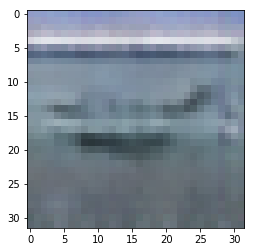

In [168]:
category = 8
print(label_list[category])
imgs = generate_images(G, category, 10)
plt.imshow(imgs[1].cpu().permute(1,2,0).numpy())

In [108]:
print("test")

test
